In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc


In [2]:

dataset = 'replogle_v2'
fold = -1
methods = ['cpa', 'scvi', 'txpert', 'txpert-llm', 'txpert-deloss', 'random-flow']
dfs = []
for method in methods:
	result_dir = f"{method}_{dataset}/fold{fold}/cell-eval-outdir"
	agg_result = pd.read_csv(os.path.join(result_dir, "agg_results.csv"))
	agg_result['method'] = method
	dfs.append(agg_result)

agg_result = pd.concat(dfs)
# agg_result

In [3]:
agg_result.loc[agg_result['statistic'] == 'mean', ['overlap_at_N', 'method']].values


array([[0.127819211548557, 'cpa'],
       [0.0708494485458366, 'scvi'],
       [0.2161979727397012, 'txpert'],
       [0.1827040384820533, 'txpert-llm'],
       [0.1205235963424664, 'txpert-deloss'],
       [0.1294407999129581, 'random-flow']], dtype=object)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_single_metric_matplotlib(
    df,
    metric,                 # e.g. "roc_auc"
    models,                 # e.g. ["txpert","scvi","cpa"]
    *,
    model_col="method",
    stat_col="statistic",
    title=None,
    ax=None,
    fontsize=14,
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    # -------- 取 mean / std / median --------
    means = []
    stds = []
    medians = []

    for model in models:
        row_mean = df[(df[model_col] == model) & (df[stat_col] == "mean")]
        row_std  = df[(df[model_col] == model) & (df[stat_col] == "std")]
        row_med  = df[(df[model_col] == model) & (df[stat_col] == "50%")]

        means.append(row_mean[metric].values[0] if not row_mean.empty else np.nan)
        stds.append(row_std[metric].values[0]  if not row_std.empty  else np.nan)
        medians.append(row_med[metric].values[0] if not row_med.empty else None)

    means = np.asarray(means, dtype=float)
    stds = np.asarray(stds, dtype=float)

    # -------- 画 bar --------
    x = np.arange(len(models))
    bar_width = 0.6

    color_map = {
        "txpert": "royalblue",
        "scvi": "#B8860B",
        "cpa": "#DAA520",
        "txpert-llm": "red",
        "txpert-deloss": "orange",
        "random-flow": "purple",
    }
    colors = [color_map.get(m, "gray") for m in models]

    ax.bar(
        x,
        means,
        width=bar_width,
        yerr=stds,
        capsize=3,
        color=colors,
        edgecolor="black",
        linewidth=1.2,
        zorder=2,
    )

    # -------- 每个 model 画 median 线 --------
    for i, med in enumerate(medians):
        if med is None or np.isnan(med):
            continue
        ax.hlines(
            med,
            i - bar_width / 2,
            i + bar_width / 2,
            colors="darkred",
            linewidth=2.0,
            zorder=3,
        )

    # -------- 美化 --------
    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=fontsize)
    ax.tick_params(axis="y", labelsize=fontsize)
    ax.set_title(title or metric, fontsize=fontsize)
    ax.grid(axis="y", linestyle="--", alpha=0.5, zorder=0)

    return ax


In [5]:
import math
import matplotlib.pyplot as plt

def plot_metrics_grid(
    df,
    metrics,          # list[str]  每个元素画一张图（单个metric）
    models,
    *,
    model_col="model",
    stat_col="statistic",
    title_prefix=None,     # 可选：每张图标题前缀
    max_cols=3,
    fontsize=14,
    figsize_per=(4.2, 3.8),  # (w,h) 每个子图大小
    sharey=False,
):
    n = len(metrics)
    if n == 0:
        raise ValueError("metrics is empty")

    ncols = min(max_cols, n)
    nrows = math.ceil(n / ncols)

    fig_w = figsize_per[0] * ncols
    fig_h = figsize_per[1] * nrows
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(fig_w, fig_h),
        squeeze=False,
        sharey=sharey
    )

    for i, metric in enumerate(metrics):
        r, c = divmod(i, ncols)
        ax = axes[r, c]
        title = metric if title_prefix is None else f"{title_prefix}: {metric}"

        plot_single_metric_matplotlib(
            df,
            metric=metric,
            models=models,
            title=title,
            ax=ax,
            fontsize=fontsize,
        )

        # 单个 metric 时 x 轴标签会重复，稍微美化一下
        ax.tick_params(axis="x", rotation=45)

    # 把多余的空子图关掉
    for j in range(n, nrows * ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    plt.tight_layout()
    return fig, axes


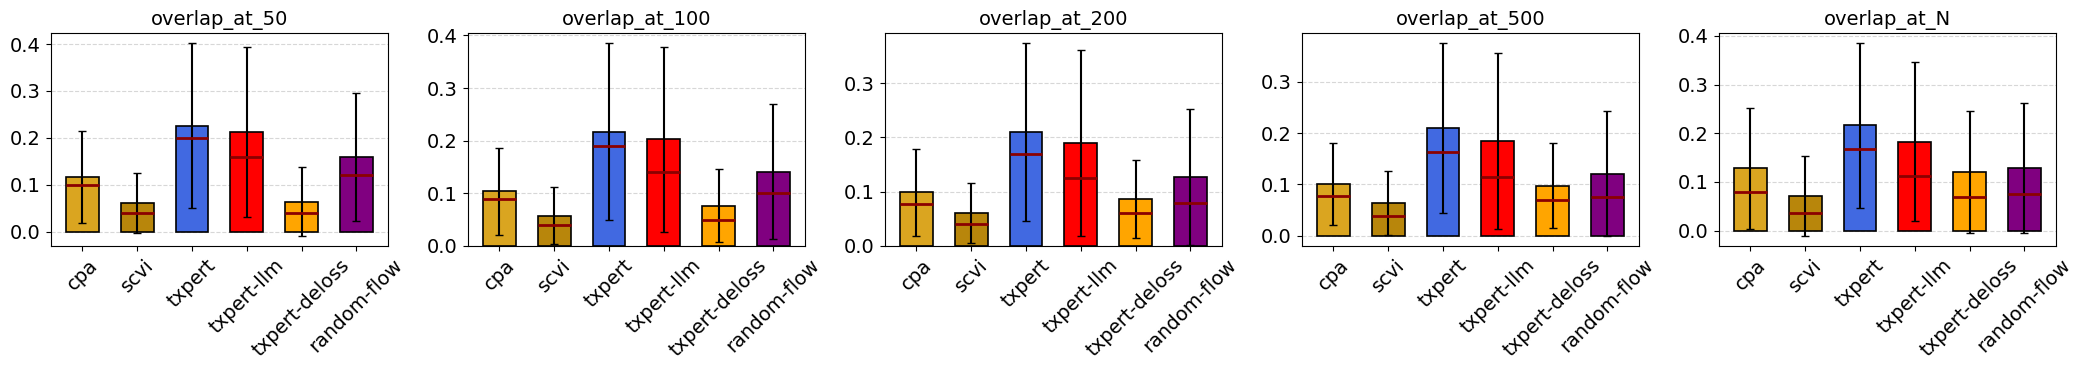

In [6]:
fig, axes = plot_metrics_grid(
    agg_result,                       # 你的 long-form df（含 mean/std）
    metrics=['overlap_at_50', 'overlap_at_100', 'overlap_at_200', 'overlap_at_500', 'overlap_at_N'],  # len(metrics) 张图
    models=methods,
    model_col="method",
    stat_col="statistic",
    max_cols=5,
    fontsize=14
)

plt.show()


In [7]:
agg_result.columns

Index(['statistic', 'overlap_at_N', 'overlap_at_50', 'overlap_at_100',
       'overlap_at_200', 'overlap_at_500', 'precision_at_N', 'precision_at_50',
       'precision_at_100', 'precision_at_200', 'precision_at_500',
       'de_spearman_sig', 'de_direction_match', 'de_spearman_lfc_sig',
       'de_sig_genes_recall', 'de_nsig_counts_real', 'de_nsig_counts_pred',
       'pr_auc', 'roc_auc', 'pearson_delta', 'mse', 'mae', 'mse_delta',
       'mae_delta', 'discrimination_score_l1', 'discrimination_score_l2',
       'discrimination_score_cosine', 'pearson_edistance',
       'clustering_agreement', 'method'],
      dtype='object')

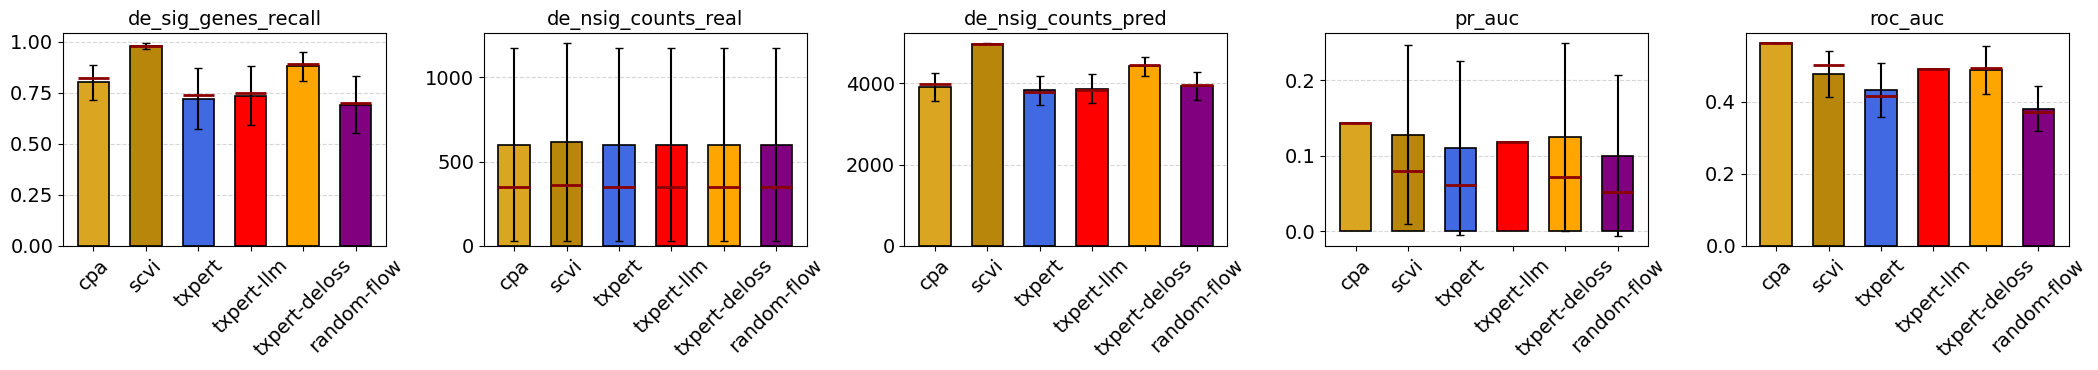

In [9]:
# metrics = ['overlap_at_50', 'overlap_at_100', 'overlap_at_200', 'overlap_at_500', 'overlap_at_N']
# metrics = ['precision_at_50', 'precision_at_100', 'precision_at_200', 'precision_at_500', 'precision_at_N']
# metrics = ['de_direction_match', 'de_spearman_sig', 'de_spearman_lfc_sig']
metrics = ['de_sig_genes_recall', 'de_nsig_counts_real', 'de_nsig_counts_pred', 'pr_auc', 'roc_auc']
# metrics = ['discrimination_score_l1', 'discrimination_score_l2', 'discrimination_score_cosine', 'pearson_edistance']
# metrics = ['pearson_delta', 'mse_delta', 'mae_delta', 'mse', 'mae']
fig, axes = plot_metrics_grid(
    agg_result,                       # 你的 long-form df（含 mean/std）
    metrics=metrics,  # len(metrics) 张图
    models=methods,
    model_col="method",
    stat_col="statistic",
    max_cols=5,
    fontsize=14
)
plt.show()
